# <span style="color:brown"> Markowitz solution: Evaluation of the most constervative call option price with real market data </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel
from numpy import exp, sqrt, log
import lets_be_rational.LetsBeRational as lbr
import time, sys
from montecarlo import MC_Analisys, MC
from matplotlib import ticker
from read_market import MarketDataReader
from scipy.stats import gmean
from targetvol import time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy

## Parsing market data

In [2]:
reader = MarketDataReader("TV_example.xml")
correlation_matrix = reader.get_correlation()
N_equity = len(correlation_matrix)
names = reader.get_stock_names()
spot_prices = reader.get_spot_prices()
D = reader.get_discounts()
F = reader.get_forward_curves()
V = reader.get_volatilities()

zero interest rate time grid [0.00000000e+00 2.73972603e-03 5.47945205e-03 8.21917808e-03
 2.46575342e-02 4.38356164e-02 6.30136986e-02 9.31506849e-02
 1.72602740e-01 2.57534247e-01 3.42465753e-01 4.24657534e-01
 5.15068493e-01 5.91780822e-01 6.76712329e-01 7.31506849e-01
 7.53424658e-01 9.83561644e-01 1.00547945e+00 1.23287671e+00
 1.47945205e+00 1.72602740e+00 1.98082192e+00 2.01095890e+00
 2.23013699e+00 3.00821918e+00 4.00821918e+00 5.00821918e+00
 6.00821918e+00 7.00821918e+00 8.01369863e+00 9.01095890e+00
 1.00109589e+01 1.10109589e+01 1.20136986e+01 1.30191781e+01
 1.40164384e+01 1.50136986e+01 1.60164384e+01 1.70164384e+01
 1.80164384e+01 1.90219178e+01 2.00191781e+01 2.10191781e+01
 2.20191781e+01 2.30191781e+01 2.40273973e+01 2.50246575e+01
 2.60219178e+01 2.70219178e+01 2.80246575e+01 2.90246575e+01
 3.00301370e+01 3.10273973e+01 3.20273973e+01 3.30273973e+01
 3.40273973e+01 3.50273973e+01 3.60328767e+01 3.70301370e+01
 3.80301370e+01 3.90301370e+01 4.00328767e+01 5.00383562

#### Correlation matrix

In [3]:
correlation_matrix

array([[1.  , 0.82, 0.86, 0.86, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.82, 1.  , 0.75, 0.77, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.86, 0.75, 1.  , 0.77, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.86, 0.77, 0.77, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

#### Discounting curve


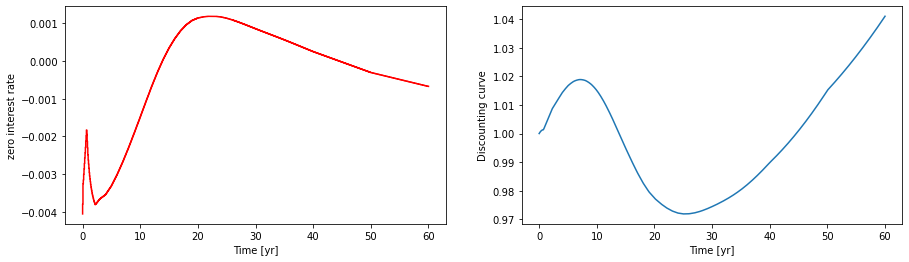

In [4]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
x = np.linspace(0,60,1000)
plt.step(x, D.r(x), color="red")
plt.xlabel("Time [yr]")
plt.ylabel("zero interest rate")

plt.subplot(1,2,2)
plt.plot(x, D(x))
plt.xlabel("Time [yr]")
plt.ylabel("Discounting curve")
plt.show()

#### Equity spot prices

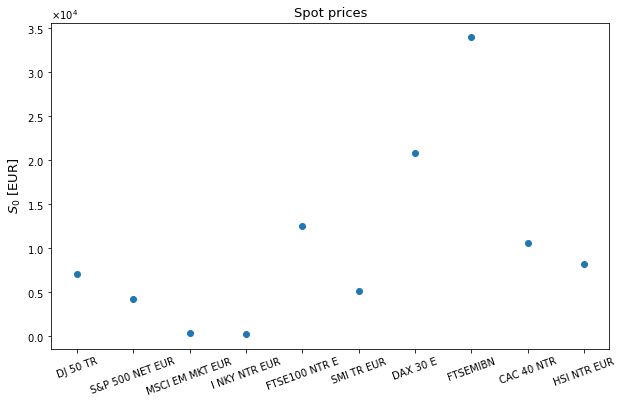

Spot prices:  [ 7084.62        4226.3168       405.06122627   284.5478
 12501.29        5105.69271854 20863.4254     33970.46
 10587.37        8238.3056    ]


In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.xticks([1, 2, 3,4,5,6,7,8,9,10], names,rotation=20)  # Set text labels and properties.
plt.scatter([1, 2, 3,4,5,6,7,8,9,10],spot_prices)
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
plt.title("Spot prices",fontsize=13)
plt.ylabel("$S_0$ [EUR]", fontsize = 13)
#plt.savefig("spot_prices.pdf")
plt.show()
print("Spot prices: ",spot_prices)

## Preparing the temporal structure for volatilities and EA

In [6]:
mu = Drift(F)
print("\n")
nu = CholeskyTDependent(V,correlation_matrix)

Drift time grid: [0.00000000e+00 2.73972603e-03 4.87671233e-01 1.48493151e+00
 2.48219178e+00 3.47945205e+00 4.49589041e+00 5.49315068e+00]
Drift values: [[ 0.0039     -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0039     -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0039     -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0041978  -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0043489  -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0038511  -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.00365768 -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.00344918 -0.002      -

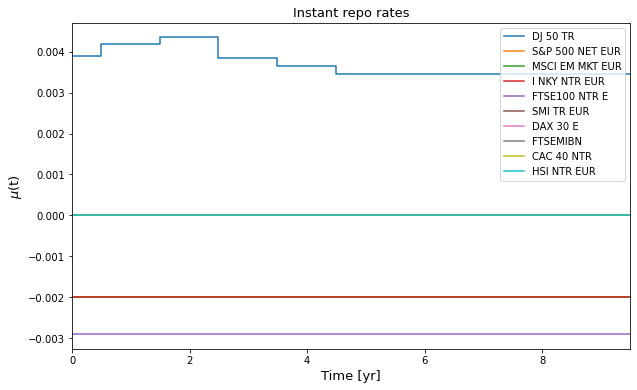

In [7]:
dimension_points = 12
plt.figure(figsize=(10,6))
for i in range(N_equity):
    time = np.array([])
    repo = np.array([])
    time = np.append(time,F[i].T)
    repo = np.append(repo,F[i].q_values)
    time = np.append(time,nu.T[len(nu.T)-1])
    repo = np.append(repo,F[i].q_values[len(repo)-1])
    plt.step(time,repo,label=names[i])
    
plt.legend()
plt.xlim(0,nu.T[len(nu.T)-1])
plt.title('Instant repo rates', fontsize=13)
plt.xlabel("Time [yr]", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
#plt.savefig("Istant_repo_rates.pdf")
plt.show()

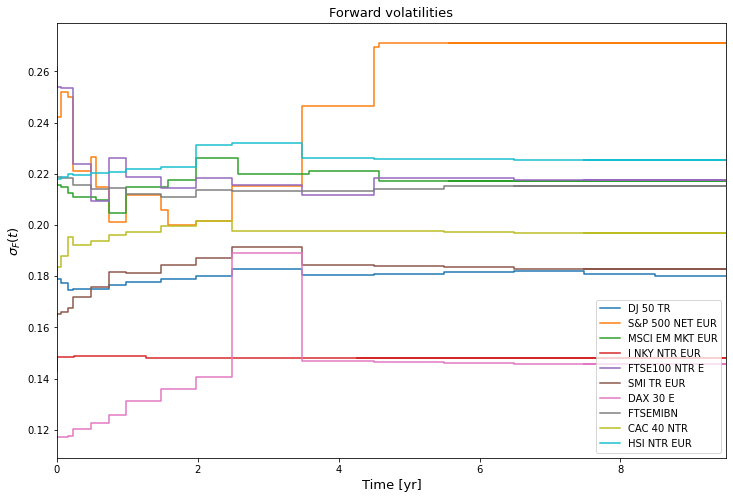

In [8]:
plt.figure(figsize=(12,8))
plt.title('Forward volatilities', fontsize=13)
for i in range(N_equity):
    time = V[i].T.tolist()
    vola = V[i].forward_vol.tolist()
    time.insert(0,V[i].T[0])
    time.insert(0,0)
    time.insert(len(time)-1,nu.T[len(nu.T)-1])
    vola.insert(0,V[i].forward_vol[0])
    vola.insert(0,V[i].forward_vol[0])
    vola.insert(len(vola)-1,V[i].forward_vol[len(V[i].forward_vol)-1])
    plt.step(time,vola,label=names[i],where='pre')
plt.legend()
plt.xlabel("Time [yr]",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
plt.xlim(0,nu.T[len(nu.T)-1])
#plt.savefig("forward_volatilities.pdf")
plt.show()

## Monte Carlo Simulation

In [9]:
"""Monte carlo simulation parameters"""
I_0 = gmean(spot_prices)  #using as value for the TVS price at time 0 the gmean of the spot prices
vol_target = 1/N_equity*sqrt(np.sum(nu(0)@nu(0).T))  #using as target volatility the volatility for a geometric basket at the reference date
print("Target volatility: ",vol_target)
K = I_0   #ATM pricing
simulations = 1e6
N_block = 100
kind = 1 #call option
print("Spot price ",I_0)

Target volatility:  0.08631132203436905
Spot price  5169.0139564601195


### Unconstrained optimization for the allocation strategy: markowitz solution

Markowitz strategy time grid : [0.00000000e+00 2.73972603e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 5.64383562e-01
 7.36986301e-01 9.86301370e-01 1.26301370e+00 1.48493151e+00
 1.58082192e+00 1.98356164e+00 2.26027397e+00 2.48219178e+00
 2.57808219e+00 3.25753425e+00 3.47945205e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.57260274e+00 5.49315068e+00
 5.56986301e+00 6.49041096e+00 7.48767123e+00 8.48493151e+00
 9.50136986e+00]
Markowitz strategy :  [[-14.28899171   2.36238386   4.58610468   8.24073467   0.48443193
   -0.          -0.          -0.          -0.          -0.        ]
 [-14.28899171   2.36238386   4.58610468   8.24073467   0.48443193
   -0.          -0.          -0.          -0.          -0.        ]
 [-14.35819215   2.23014281   4.62517176   8.26313032   0.5136404
   -0.          -0.          -0.          -0.          -0.        ]
 [-14.45532017   2.10108871   4.66895985   8.2881259    0.51249819
   -0.          -0.          -0.

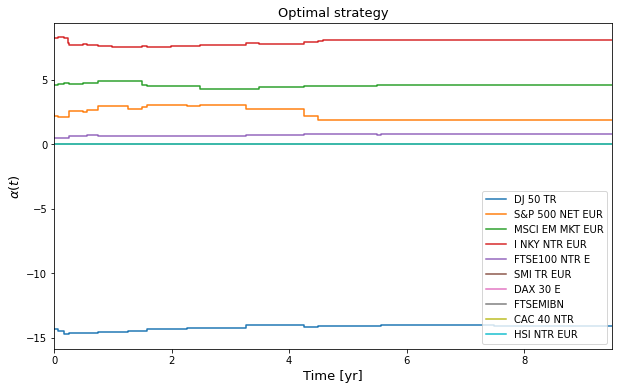

In [10]:
alpha = Strategy()
alpha.Mark_strategy(mu=mu,nu=nu)

plt.figure(figsize=(10,6))
plt.title("Optimal strategy",fontsize=13)
for i in range(N_equity):
    plt.step(alpha.T,alpha.alpha_t.T[i],label=names[i])
plt.legend()
plt.xlabel("Time [yr]",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
plt.xlim(0,alpha.T[len(alpha.T)-1])
#plt.savefig("unconstrained_optimal_strategy.pdf")
plt.show()

In [15]:
print(dates)

[0.00000000e+00 2.73972603e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 5.64383562e-01
 7.36986301e-01 9.86301370e-01 1.26301370e+00 1.48493151e+00
 1.58082192e+00 1.98356164e+00 2.26027397e+00 2.48219178e+00
 2.57808219e+00 3.25753425e+00 3.47945205e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.57260274e+00 5.49315068e+00
 5.56986301e+00 6.49041096e+00 7.48767123e+00 8.48493151e+00
 9.50136986e+00]


In [22]:
alpha.T

array([0.00000000e+00, 2.73972603e-03, 6.57534247e-02, 1.61643836e-01,
       2.38356164e-01, 2.46575342e-01, 4.87671233e-01, 5.64383562e-01,
       7.36986301e-01, 9.86301370e-01, 1.26301370e+00, 1.48493151e+00,
       1.58082192e+00, 1.98356164e+00, 2.26027397e+00, 2.48219178e+00,
       2.57808219e+00, 3.25753425e+00, 3.47945205e+00, 3.57534247e+00,
       4.25479452e+00, 4.49589041e+00, 4.57260274e+00, 5.49315068e+00,
       5.56986301e+00, 6.49041096e+00, 7.48767123e+00, 8.48493151e+00,
       9.50136986e+00])

In [23]:
%%time
dates = alpha.T
dates = np.append(dates,alpha.T[len(alpha.T)-1])
print(dates)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
print("Path simulation")
I_t,forward = TVS.simulate(fixings = np.array([10.5]),Nsim=simulations, seed=7, ret_forward=1)   #11 for 5.25
print("Payoff")
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
print("Data blocking")
x, result_mark, result_err_mark = MC_Analisys(pay[:,-1],N_block)

[0.00000000e+00 2.73972603e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 5.64383562e-01
 7.36986301e-01 9.86301370e-01 1.26301370e+00 1.48493151e+00
 1.58082192e+00 1.98356164e+00 2.26027397e+00 2.48219178e+00
 2.57808219e+00 3.25753425e+00 3.47945205e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.57260274e+00 5.49315068e+00
 5.56986301e+00 6.49041096e+00 7.48767123e+00 8.48493151e+00
 9.50136986e+00 9.50136986e+00]
Path simulation
Payoff
Data blocking
CPU times: user 1.17 s, sys: 151 ms, total: 1.32 s
Wall time: 1.32 s


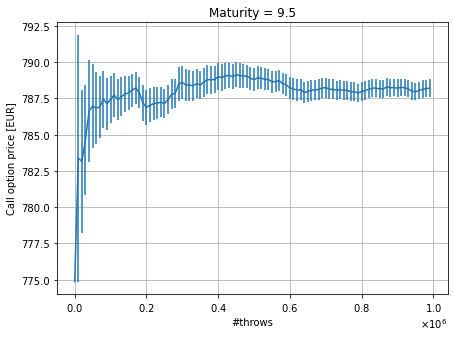

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=result_err_mark)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price [EUR]")
   # plt.savefig("TVS_call_option_price_unconstrained.pdf")
if kind == -1:
    plt.ylabel("Put option price [EUR]")
#    plt.savefig("TVS_put_option_price_unconstrained.pdf")
    
plt.show()

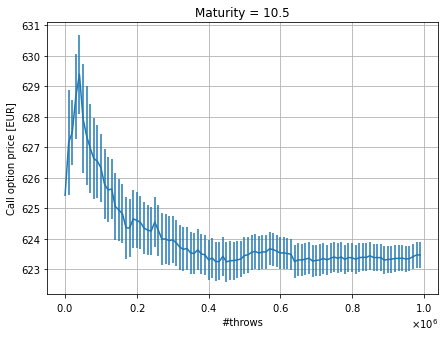

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=result_err_mark)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price [EUR]")
   # plt.savefig("TVS_call_option_price_unconstrained.pdf")
if kind == -1:
    plt.ylabel("Put option price [EUR]")
#    plt.savefig("TVS_put_option_price_unconstrained.pdf")
    
plt.show()

In [13]:
n = len(dates)-1
X_t = I_t/forward
pay_normalized = Vanilla_PayOff(St=X_t,strike=K/forward, typo=kind)
x, result, result_err = MC_Analisys(pay_normalized[:,n],N_block)
imp_volatility_mean = np.zeros(N_block)
imp_volatility_plus = np.zeros(N_block)
imp_volatility_minus = np.zeros(N_block)
print("Calculating implied volatility")
for i in range (N_block):
    imp_volatility_mean[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],1,K/forward[n],dates[n],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+result_err[i],1,K/forward[n],dates[n],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-result_err[i],1,K/forward[n],dates[n],kind)

print("Error analysis")    
y_lower = np.zeros(N_block)
y_upper = np.zeros(N_block)
for i in range(N_block):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility_mean[i]-imp_volatility_minus[i])
        y_upper[i] = abs(imp_volatility_plus[i]-imp_volatility_mean[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility[i]-imp_volatility_plus[i])
        y_upper[i] = abs(imp_volatility_minus[i]-imp_volatility_mean[i])


Calculating implied volatility
Error analysis


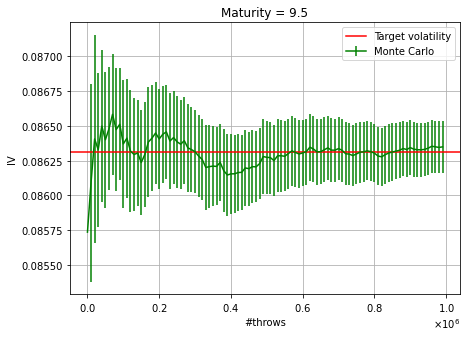

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,imp_volatility_mean,yerr=[2*y_lower,2*y_upper], label = "Monte Carlo", color="green")
plt.axhline(y=vol_target,color= "red",label = 'Target volatility')
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel("IV")
plt.legend()
#plt.savefig("IV_price_unconstrained.pdf")
plt.show()

#### Checking price vs volatility

In [18]:
%%time
volatility_grid = np.arange(1,11)*0.05
price = np.zeros(len(volatility_grid))
price_error = np.zeros(len(volatility_grid))
for i in range(len(volatility_grid)):
    TVSF = TVSForwardCurve(reference = 0., vola_target =volatility_grid[i], spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,10]))
    TVS = TargetVolatilityStrategy(forward_curve=TVSF)
    I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
    pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
    price[i],price_error[i] = MC(pay.T[len(dates)-1])   

CPU times: user 3min 57s, sys: 28.2 s, total: 4min 25s
Wall time: 3min 16s


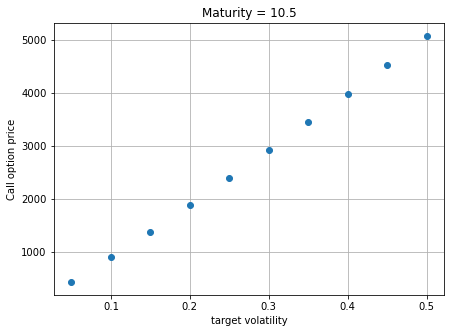

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(volatility_grid,price,yerr=price_error, fmt='o')
plt.xlabel("target volatility")
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
plt.grid(True)
#plt.savefig("Markowitz_convergence_with_euler.pdf")
plt.show()

### Constrained optimization for the allocation strategy: 
### $$\sum_i \alpha_i = 1\quad \text{with}\quad \alpha_i>0$$

Optimal strategy time grid : [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 4.94444444e-01
 5.64383562e-01 7.36986301e-01 9.86301370e-01 1.26301370e+00
 1.48493151e+00 1.50555556e+00 1.58082192e+00 1.98356164e+00
 2.26027397e+00 2.48219178e+00 2.51666667e+00 2.57808219e+00
 3.25753425e+00 3.47945205e+00 3.52777778e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.55833333e+00 4.57260274e+00
 5.25205479e+00 5.49315068e+00 5.56944444e+00 5.56986301e+00
 6.49041096e+00 7.48767123e+00 8.48493151e+00 9.50136986e+00
 1.04986301e+01]
Optimal strategy through minimization:  [[-5.62530300e-16  1.13279318e-01  2.28064008e-01  5.90438305e-01
   6.79455158e-02  8.52741244e-05 -1.47281615e-15  2.77284706e-16
   6.51603902e-05  1.22418690e-04]
 [-5.62530300e-16  1.13279318e-01  2.28064008e-01  5.90438305e-01
   6.79455158e-02  8.52741244e-05 -1.47281615e-15  2.77284706e-16
   6.51603902e-05  1.22418690e-04]
 [ 1.11170398e-15  1.13279319e-

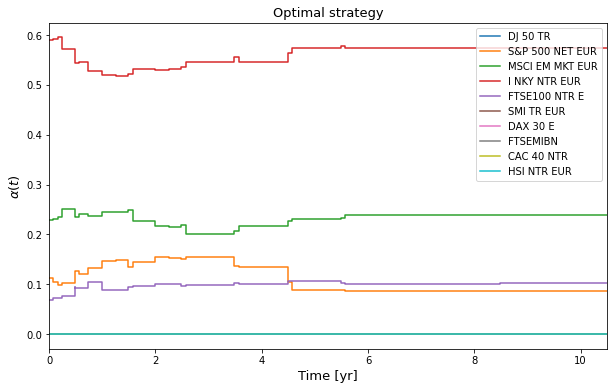

CPU times: user 6.79 s, sys: 4.36 ms, total: 6.79 s
Wall time: 6.79 s


In [20]:
%%time
alpha.optimization_constrained(mu=mu,nu=nu,N_trial=10)
plt.figure(figsize=(10,6))
plt.title("Optimal strategy",fontsize=13)
for i in range(N_equity):
    plt.step(alpha.T,alpha.alpha_t.T[i],label=names[i])
plt.legend()
plt.xlabel("Time [yr]",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
plt.xlim(0,alpha.T[len(alpha.T)-1])
#plt.savefig("only_long_optimal_strategy.pdf")
plt.show()

In [21]:
%%time
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
print("Path simulation")
I_t, forward = TVS.simulate(fixings = dates,Nsim=simulations, seed=11, ret_forward=1)
print("Forward at maturity:", TVSF(dates[len(dates)-1]))
print("Payoff")
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
print("Data blocking")
x, result_opt1, result_err_opt1 = MC_Analisys(pay[:,len(dates)-1],N_block)

Path simulation
Forward at maturity: 5239.405863364911
Payoff
Data blocking
CPU times: user 24.5 s, sys: 2.66 s, total: 27.1 s
Wall time: 20.1 s


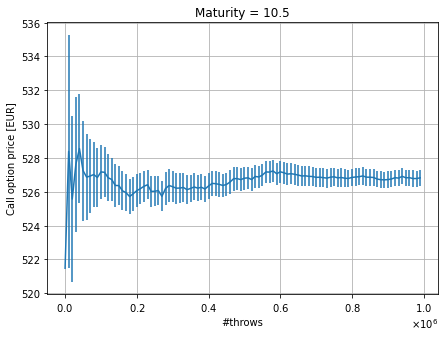

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_opt1,yerr=result_err_opt1)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price [EUR]")
    #plt.savefig("TVS_call_option_price_only_long.pdf")
if kind == -1:
    plt.ylabel("Put option price [EUR]")
#    plt.savefig("TVS_put_option_price_only_long.pdf")
    
plt.show()

In [23]:
n = len(dates)-1
X_t = I_t/forward
pay_normalized = Vanilla_PayOff(St=X_t,strike=K/forward, typo=kind)
x, result, result_err = MC_Analisys(pay_normalized[:,n],N_block)
imp_volatility_mean = np.zeros(N_block)
imp_volatility_plus = np.zeros(N_block)
imp_volatility_minus = np.zeros(N_block)
print("Calculating implied volatility")
for i in range (N_block):
    imp_volatility_mean[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],1,K/forward[n],dates[n],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+result_err[i],1,K/forward[n],dates[n],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-result_err[i],1,K/forward[n],dates[n],kind)

print("Error analysis")    
y_lower = np.zeros(N_block)
y_upper = np.zeros(N_block)
for i in range(N_block):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility_mean[i]-imp_volatility_minus[i])
        y_upper[i] = abs(imp_volatility_plus[i]-imp_volatility_mean[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility[i]-imp_volatility_plus[i])
        y_upper[i] = abs(imp_volatility_minus[i]-imp_volatility_mean[i])


Calculating implied volatility
Error analysis


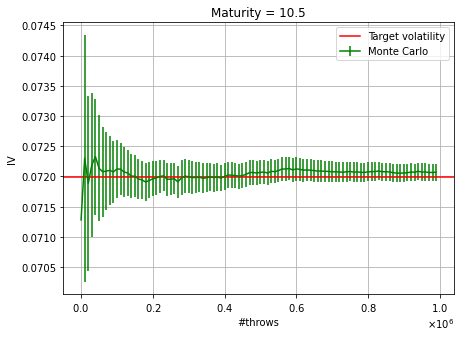

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,imp_volatility_mean,yerr=[2*y_lower,2*y_upper], label = "Monte Carlo", color="green")
plt.axhline(y=vol_target,color= "red",label = 'Target volatility')
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel("IV")
plt.legend()
#plt.savefig("IV_price_only_long.pdf")
plt.show()

#### This constrained strategy wins over intuitive strategies?

In [25]:
%%time
alpha.Intuitive_strategy1(forward_curves=F, maturity_date=np.max(dates))
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings= dates,Nsim=simulations, seed=7)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive1, result_err_intuitive1 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 0.         10.49863014]
Intuitive strategy (invest all on the asset with maximum growth at maturity)  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
CPU times: user 24.8 s, sys: 2.95 s, total: 27.8 s
Wall time: 20.4 s


In [26]:
%%time
alpha.Intuitive_strategy2(mu=mu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive2, result_err_intuitive2 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [0.00000000e+00 2.77777778e-03 4.94444444e-01 1.50555556e+00
 2.51666667e+00 3.52777778e+00 4.55833333e+00 5.56944444e+00]
Intuitive strategy (invest all on the asset with minimum mu parameter) [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
CPU times: user 24.1 s, sys: 2.99 s, total: 27.1 s
Wall time: 20.4 s


In [27]:
%%time
alpha.Intuitive_strategy3(mu=mu,nu=nu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive3, result_err_intuitive3 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 4.94444444e-01
 5.64383562e-01 7.36986301e-01 9.86301370e-01 1.26301370e+00
 1.48493151e+00 1.50555556e+00 1.58082192e+00 1.98356164e+00
 2.26027397e+00 2.48219178e+00 2.51666667e+00 2.57808219e+00
 3.25753425e+00 3.47945205e+00 3.52777778e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.55833333e+00 4.57260274e+00
 5.25205479e+00 5.49315068e+00 5.56944444e+00 5.56986301e+00
 6.49041096e+00 7.48767123e+00 8.48493151e+00 9.50136986e+00
 1.04986301e+01]
Intuitive strategy (invest all on the asset with minimum mu/||nu|| parameter) [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 

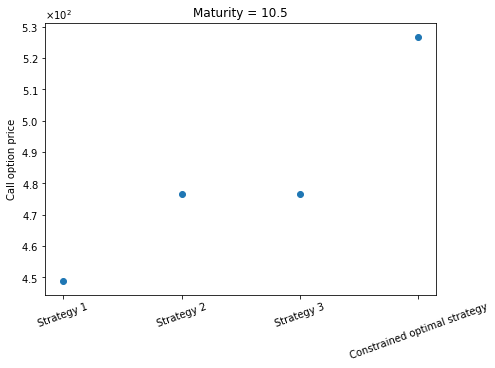

In [28]:
n =len(dates)-1
errori = np.array([result_err_intuitive1[N_block-1],result_err_intuitive2[N_block-1],result_err_intuitive3[N_block-1],result_err_opt1[N_block-1]])
risultati = err = np.array([result_intuitive1[N_block-1],result_intuitive2[N_block-1],result_intuitive3[N_block-1],result_opt1[N_block-1]])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.xticks([1, 2, 3,4], ["Strategy 1","Strategy 2", "Strategy 3", "Constrained optimal strategy"],rotation=20)  # Set text labels and properties.
plt.errorbar([1, 2, 3,4],risultati,errori,fmt='o')
plt.title("Maturity = "+str(round(dates[n],2)))
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
ax.yaxis.set_major_formatter(formatter)
#plt.savefig("strategy_comparison.pdf")
plt.show()

### Constrained optimization for the allocation strategy: 
### $$\left|\alpha_i\right| \leq 10\% \quad \forall i$$

Optimal strategy time grid : [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 4.94444444e-01
 5.64383562e-01 7.36986301e-01 9.86301370e-01 1.26301370e+00
 1.48493151e+00 1.50555556e+00 1.58082192e+00 1.98356164e+00
 2.26027397e+00 2.48219178e+00 2.51666667e+00 2.57808219e+00
 3.25753425e+00 3.47945205e+00 3.52777778e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.55833333e+00 4.57260274e+00
 5.25205479e+00 5.49315068e+00 5.56944444e+00 5.56986301e+00
 6.49041096e+00 7.48767123e+00 8.48493151e+00 9.50136986e+00
 1.04986301e+01]
Optimal strategy through minimization:  [[-4.44721213e-02  7.19746946e-02  8.26159315e-02  1.00000000e-01
   4.95573366e-03  7.07887845e-06 -6.73048893e-06  7.94818500e-06
  -5.40668167e-06 -2.03834202e-06]
 [-4.44721213e-02  7.19746946e-02  8.26159315e-02  1.00000000e-01
   4.95573366e-03  7.07887845e-06 -6.73048893e-06  7.94818500e-06
  -5.40668167e-06 -2.03834202e-06]
 [-4.44721213e-02  7.19746946e-

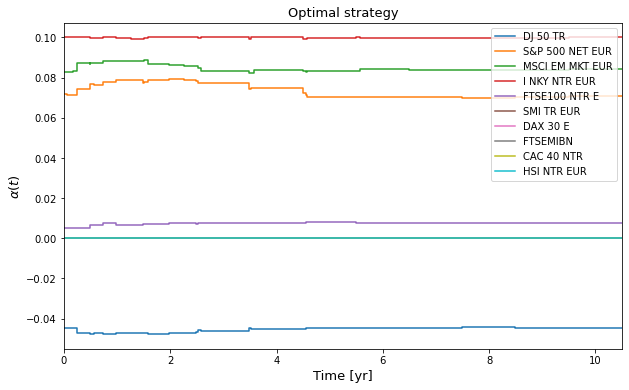

CPU times: user 6.99 s, sys: 8.61 ms, total: 7 s
Wall time: 6.99 s


In [29]:
%%time
alpha.optimization_constrained(mu=mu,nu=nu,N_trial=10, long_limit=10/100, typo=2)

plt.figure(figsize=(10,6))
plt.title("Optimal strategy",fontsize=13)
for i in range(N_equity):
    plt.step(alpha.T,alpha.alpha_t.T[i],label=names[i])
plt.legend()
plt.xlabel("Time [yr]",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
plt.xlim(0,alpha.T[len(alpha.T)-1])
#plt.savefig("mod_limited_optimal_strategy.pdf")
plt.show()

In [30]:
%%time
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
print("Path simulation")
I_t, forward = TVS.simulate(fixings = dates,Nsim=simulations, seed=7,ret_forward=1)
print("Forward at maturity:", TVSF(dates[len(dates)-1]))
print("Payoff")
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
print("Data blocking")
x, result_opt2, result_err_opt2 = MC_Analisys(pay[:,len(dates)-1],N_block)

Path simulation
Forward at maturity: 5401.29851301941
Payoff
Data blocking
CPU times: user 26.3 s, sys: 2.86 s, total: 29.1 s
Wall time: 22.1 s


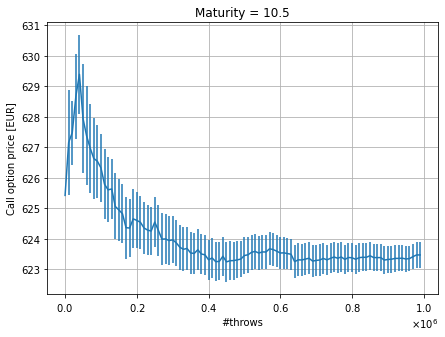

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_opt2,yerr=result_err_opt2)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price [EUR]")
    #plt.savefig("TVS_call_option_price_mod_limited.pdf")
if kind == -1:
    plt.ylabel("Put option price [EUR]")
#    plt.savefig("TVS_put_option_price_mod_limited.pdf")
    
plt.show()

In [32]:
n = len(dates)-1
X_t = I_t/forward
pay_normalized = Vanilla_PayOff(St=X_t,strike=K/forward, typo=kind)
x, result, result_err = MC_Analisys(pay_normalized[:,n],N_block)
imp_volatility_mean = np.zeros(N_block)
imp_volatility_plus = np.zeros(N_block)
imp_volatility_minus = np.zeros(N_block)
print("Calculating implied volatility")
for i in range (N_block):
    imp_volatility_mean[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],1,K/forward[n],dates[n],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+result_err[i],1,K/forward[n],dates[n],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-result_err[i],1,K/forward[n],dates[n],kind)

print("Error analysis")    
y_lower = np.zeros(N_block)
y_upper = np.zeros(N_block)
for i in range(N_block):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility_mean[i]-imp_volatility_minus[i])
        y_upper[i] = abs(imp_volatility_plus[i]-imp_volatility_mean[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility[i]-imp_volatility_plus[i])
        y_upper[i] = abs(imp_volatility_minus[i]-imp_volatility_mean[i])


Calculating implied volatility
Error analysis


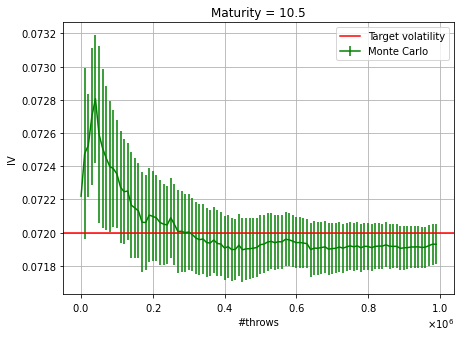

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,imp_volatility_mean,yerr=[2*y_lower,2*y_upper], label = "Monte Carlo", color="green")
plt.axhline(y=vol_target,color= "red",label = 'Target volatility')
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel("IV")
plt.legend()
#plt.savefig("IV_price_mod_limited.pdf")
plt.show()

### Constrained optimization for the allocation strategy: 
### $$\sum_i\alpha_i \leq 90\%  \quad \forall \alpha_i>0$$
### $$\left|\sum_i\alpha_i \right| \leq 10\%  \quad \forall\alpha_i<0$$

Optimal strategy time grid : [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 4.94444444e-01
 5.64383562e-01 7.36986301e-01 9.86301370e-01 1.26301370e+00
 1.48493151e+00 1.50555556e+00 1.58082192e+00 1.98356164e+00
 2.26027397e+00 2.48219178e+00 2.51666667e+00 2.57808219e+00
 3.25753425e+00 3.47945205e+00 3.52777778e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.55833333e+00 4.57260274e+00
 5.25205479e+00 5.49315068e+00 5.56944444e+00 5.56986301e+00
 6.49041096e+00 7.48767123e+00 8.48493151e+00 9.50136986e+00
 1.04986301e+01]
Optimal strategy through minimization:  [[-9.99922221e-02  1.61819808e-01  1.85745151e-01  2.24853242e-01
   1.11341125e-02  3.95087891e-07 -2.82268823e-06 -2.88697283e-06
  -2.24112400e-07 -2.06826223e-06]
 [-9.99922221e-02  1.61819808e-01  1.85745151e-01  2.24853242e-01
   1.11341125e-02  3.95087891e-07 -2.82268823e-06 -2.88697283e-06
  -2.24112400e-07 -2.06826223e-06]
 [-9.99922190e-02  1.61819804e-

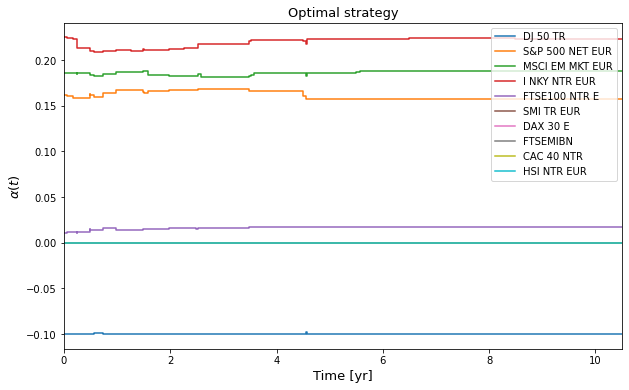

CPU times: user 15 s, sys: 563 µs, total: 15 s
Wall time: 15 s


In [34]:
%%time
alpha.optimization_constrained(mu=mu,nu=nu,N_trial=10, long_limit=90/100, short_limit=10/100, typo=3)

plt.figure(figsize=(10,6))
plt.title("Optimal strategy",fontsize=13)
for i in range(N_equity):
    plt.step(alpha.T,alpha.alpha_t.T[i],label=names[i])
plt.legend()
plt.xlabel("Time [yr]",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
plt.xlim(0,alpha.T[len(alpha.T)-1])
#plt.savefig("limited_long_short_optimal_strategy.pdf")
plt.show()

In [35]:
%%time
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
print("Path simulation")
I_t, forward = TVS.simulate(fixings = dates,Nsim=simulations, seed=7, ret_forward=1)
print("Forward at maturity:", TVSF(dates[len(dates)-1]))
print("Payoff")
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
print("Data blocking")
x, result_opt3, result_err_opt3 = MC_Analisys(pay[:,len(dates)-1],N_block)

Path simulation
Forward at maturity: 5401.298476686112
Payoff
Data blocking
CPU times: user 24.5 s, sys: 3 s, total: 27.5 s
Wall time: 21 s


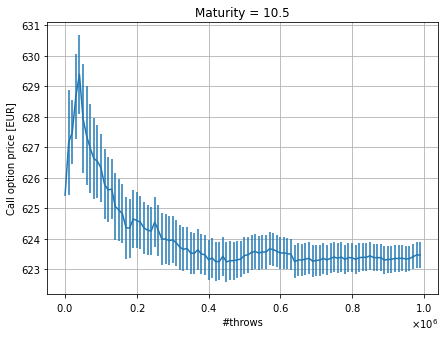

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_opt3,yerr=result_err_opt3)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price [EUR]")
    #plt.savefig("TVS_call_option_price_limited_long_short.pdf")
if kind == -1:
    plt.ylabel("Put option price [EUR]")
#    plt.savefig("TVS_put_option_price_limited_long_short.pdf")
    
plt.show()

In [37]:
n = len(dates)-1
X_t = I_t/forward
pay_normalized = Vanilla_PayOff(St=X_t,strike=K/forward, typo=kind)
x, result, result_err = MC_Analisys(pay_normalized[:,n],N_block)
imp_volatility_mean = np.zeros(N_block)
imp_volatility_plus = np.zeros(N_block)
imp_volatility_minus = np.zeros(N_block)
print("Calculating implied volatility")
for i in range (N_block):
    imp_volatility_mean[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],1,K/forward[n],dates[n],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+result_err[i],1,K/forward[n],dates[n],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-result_err[i],1,K/forward[n],dates[n],kind)

print("Error analysis")    
y_lower = np.zeros(N_block)
y_upper = np.zeros(N_block)
for i in range(N_block):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility_mean[i]-imp_volatility_minus[i])
        y_upper[i] = abs(imp_volatility_plus[i]-imp_volatility_mean[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility[i]-imp_volatility_plus[i])
        y_upper[i] = abs(imp_volatility_minus[i]-imp_volatility_mean[i])


Calculating implied volatility
Error analysis


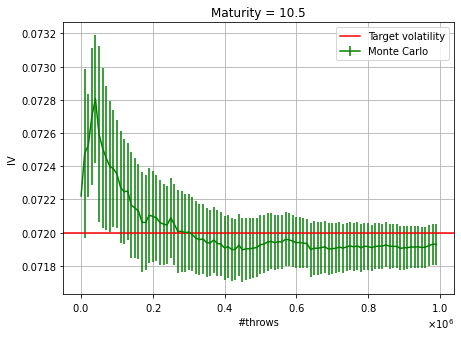

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,imp_volatility_mean,yerr=[2*y_lower,2*y_upper], label = "Monte Carlo", color="green")
plt.axhline(y=vol_target,color= "red",label = 'Target volatility')
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel("IV")
plt.legend()
#plt.savefig("IV_price_limited_long_short.pdf")
plt.show()